In [3]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import datetime

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = '../batches_news_ria_1kk'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [4]:
def print_now():
    print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))

In [5]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [6]:
#MODE = 'new'
MODE = 'load'

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

if MODE == 'new':
    print_now()

    # Удаление словаря, оставшегося после предыдущих запусков
    if os.path.isfile(dictionary_address):
        os.remove(dictionary_address)

    # Сохранение словаря в файл
    dictionary.gather(data_path=batch_vectorizer.data_path)
    dictionary.save(dictionary_path=dictionary_address)
    
    print_now()

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)

# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=10000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.0001)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.5)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

 461281 - количество слов в словаре
 123303 - количество слов в словаре после фильтрации по min_tf
 120314 - количество слов в словаре после фильтрации по max_tf
  32265 - количество слов в словаре после фильтрации по min_df_rate
  32265 - количество слов в словаре после фильтрации по max_df_rate


In [7]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [7]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    #ax.set_xlabel('//')
    #ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    #ax.set_xlabel('//')
    #ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    #ax.set_xlabel('//')
    #ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [8]:
params = {
    'topic_count': 75,
}

In [9]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

2019-06-07 13:43
2019-06-07 13:51


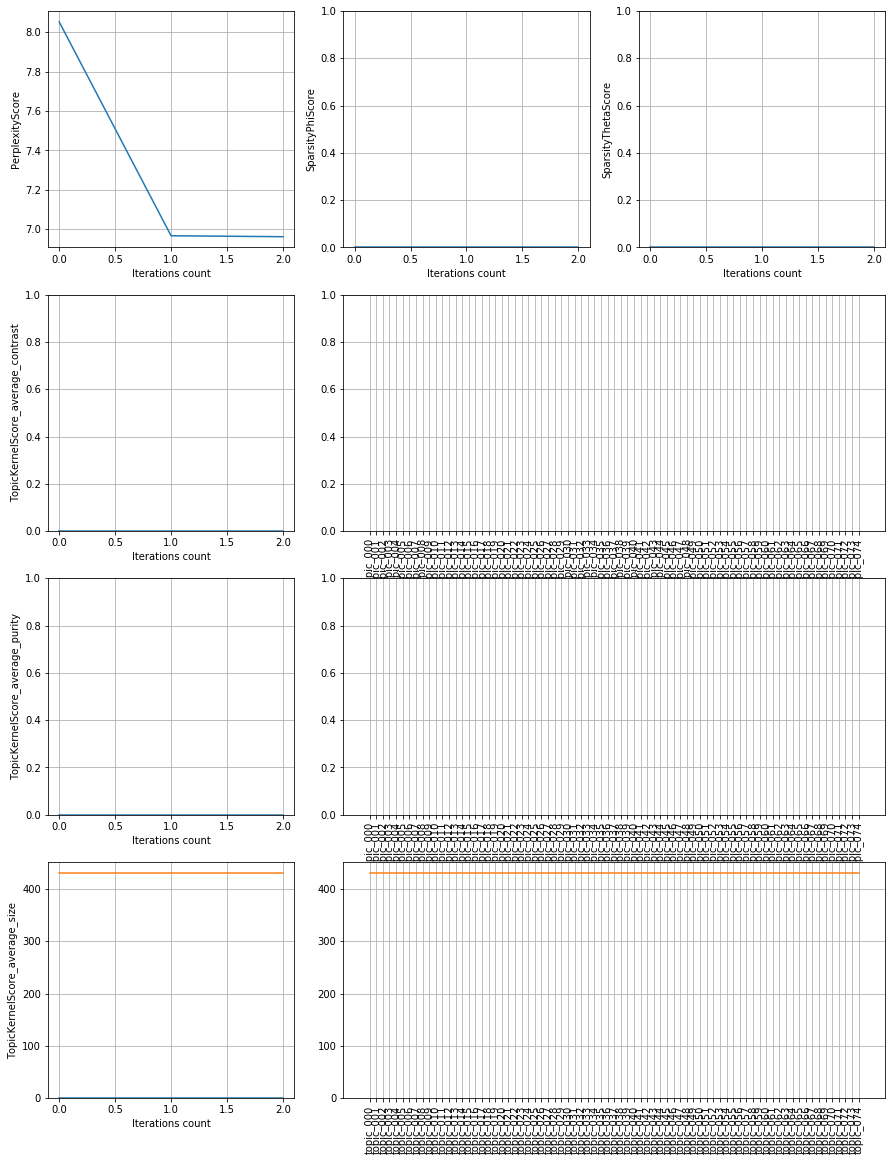

PerplexityScore: 6.962213039398193
SparsityPhiScore: 0.0
SparsityThetaScore: 0.0

TopicKernelScore_average_contrast: 0.0
TopicKernelScore_average_purity: 0.0
TopicKernelScore_average_size: 0.0

TopTokensScore:
topic_000: лукойл организм чешский фунт реставрация психолог октябрьский фукусима грозный радикал 
topic_001: соцсеть бурятия капитализация закрываться тигр керри отключение социально летчик пристав 
topic_002: эбола лихорадка фифа отключение голосовать убежище полонский урок штрафной организм 
topic_003: похищение паралимпийский калининградский психолог удерживать урок фунт социально сенат словакия 
topic_004: героин потушить йемен марш француз фунт социально ростелеком мясо устав 
topic_005: паралимпийский рогозин банда кострома генсек единоросс металл крест тюменский ныне 
topic_006: шведский обработка удостоверение организм сахалинский подъезд взрываться голосовать арсенал вена 
topic_007: магнитский ивановский прогреметь бивалютный эбола прерывать цитирование магистраль удер

In [10]:
# Модель 0_0
# Без регуляризаторов

# Обучение модели
print_now()
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)
print_now()

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

In [11]:
phi = model_artm.phi_
phi

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009,...,topic_065,topic_066,topic_067,topic_068,topic_069,topic_070,topic_071,topic_072,topic_073,topic_074
преследователь,2.448146e-05,4.014926e-05,3.376249e-06,9.263255e-06,4.157056e-06,9.168573e-06,3.197454e-05,2.432157e-05,1.450189e-05,5.869432e-06,...,3.873195e-05,2.319525e-06,2.521876e-05,1.348195e-06,1.786528e-05,1.134001e-05,2.407632e-05,2.196338e-05,2.066200e-05,4.439262e-05
тайшет,4.729158e-06,5.113830e-07,7.452852e-06,1.142227e-08,4.025590e-06,5.819191e-06,4.285374e-08,1.042397e-06,4.780527e-06,3.996951e-06,...,4.357513e-06,3.808278e-06,4.253457e-06,3.006619e-06,6.867728e-06,8.056778e-06,1.746223e-06,4.477409e-06,1.621764e-06,8.032391e-06
финкельштейн,6.858891e-06,3.535856e-06,7.568161e-06,5.230180e-06,5.159251e-07,3.508720e-06,3.860063e-06,5.496350e-06,5.726607e-06,1.763879e-06,...,2.364422e-08,5.021260e-06,1.019598e-05,1.059412e-05,2.965884e-06,6.054185e-06,3.092149e-06,2.230027e-06,9.266802e-08,6.840747e-06
подкомитет,3.923833e-05,3.665781e-06,1.455960e-05,2.229644e-05,6.355884e-06,1.127949e-06,2.994710e-05,3.181071e-05,3.718700e-05,3.156956e-06,...,2.949876e-05,2.614063e-05,1.474103e-05,5.462462e-06,3.018374e-05,3.878788e-05,1.633855e-05,1.775042e-05,2.555752e-06,1.855160e-05
джулия,2.192535e-05,2.460268e-05,2.354675e-05,2.784888e-05,6.837235e-06,3.232280e-05,1.194903e-06,6.442995e-06,1.957886e-05,9.419141e-06,...,6.834122e-06,6.363360e-06,2.658327e-05,2.947986e-05,1.390882e-05,6.341464e-06,1.665367e-05,5.090785e-07,2.925393e-05,1.232484e-05
гомофобия,3.257696e-06,4.212368e-06,3.561464e-06,4.229054e-06,1.072145e-05,5.045901e-06,7.386216e-06,2.556177e-06,6.818520e-06,1.018490e-05,...,8.894423e-06,3.154923e-06,2.421906e-06,7.379411e-06,5.878098e-06,1.856631e-06,3.159520e-06,1.930138e-06,1.717152e-06,9.265852e-06
втискивать,6.507158e-06,3.914966e-06,1.518631e-06,6.230935e-06,9.829241e-09,2.384030e-06,5.124834e-06,4.400053e-07,2.760723e-06,1.968427e-07,...,5.739506e-06,9.241334e-08,8.577268e-07,5.098591e-06,4.772789e-06,2.389134e-07,4.515308e-06,9.827642e-07,4.073731e-06,1.105046e-06
роснано,5.897694e-06,4.104789e-05,2.873335e-04,1.569364e-04,3.469760e-04,5.853049e-05,1.075400e-04,6.249628e-05,8.466728e-05,1.262851e-04,...,9.297131e-05,2.845303e-04,2.358021e-04,3.570479e-04,2.116356e-04,3.521973e-05,6.724384e-05,3.545895e-04,1.364655e-04,4.255189e-06
побратим,1.736819e-05,1.691698e-05,1.387384e-05,1.285092e-05,1.645241e-05,1.045715e-05,1.216842e-05,8.076233e-06,3.837076e-06,1.183533e-05,...,1.585125e-05,1.426873e-05,2.105609e-06,2.787276e-06,2.546397e-05,3.764180e-06,2.041154e-05,9.549435e-07,1.451405e-06,2.287622e-05
конюхов,2.913640e-06,4.133891e-06,1.546499e-06,4.480315e-06,2.645551e-06,1.438382e-05,1.605549e-06,1.075400e-05,6.518746e-06,4.288660e-06,...,6.403638e-06,8.712935e-06,2.305465e-06,6.922644e-07,2.079427e-06,7.853617e-06,7.317221e-06,5.879455e-07,1.124520e-05,9.540482e-06


In [12]:
theta = model_artm.get_theta()
theta

,428000,428001,428002,428003,428004,428005,428006,428007,428008,428009,...,212990,212991,212992,212993,212994,212995,212996,212997,212998,212999
topic_000,0.014736,0.014028,0.015700,0.014413,0.007556,0.013513,0.014843,0.012608,0.015429,0.014403,...,0.017879,0.009259,0.007029,0.013422,0.015026,0.015356,0.016973,0.011483,0.013170,0.014008
topic_001,0.012902,0.014848,0.015771,0.011966,0.011847,0.015381,0.013641,0.012800,0.014577,0.012263,...,0.014766,0.010151,0.013001,0.014423,0.010776,0.015535,0.009773,0.013188,0.012635,0.011314
topic_002,0.011596,0.014222,0.011924,0.012497,0.010180,0.012633,0.017617,0.015060,0.014783,0.015208,...,0.010701,0.013932,0.014679,0.011284,0.014534,0.010196,0.011373,0.012226,0.012478,0.011413
topic_003,0.013603,0.013667,0.014943,0.011876,0.011979,0.013637,0.024115,0.012540,0.012588,0.012490,...,0.008714,0.014285,0.011181,0.012620,0.011971,0.012325,0.014297,0.012740,0.014263,0.016657
topic_004,0.012239,0.011242,0.015018,0.013441,0.020197,0.017364,0.022622,0.010747,0.013580,0.015798,...,0.016124,0.009288,0.010397,0.014758,0.011695,0.011454,0.013270,0.014805,0.017678,0.019322
topic_005,0.012033,0.010119,0.011767,0.011403,0.015300,0.015640,0.015245,0.014425,0.012430,0.009416,...,0.013568,0.012891,0.014674,0.015443,0.014248,0.011555,0.010379,0.012039,0.012075,0.012164
topic_006,0.011479,0.013640,0.010102,0.011944,0.017770,0.009701,0.006001,0.013939,0.013321,0.008567,...,0.010831,0.010264,0.012201,0.014723,0.016591,0.014469,0.011503,0.018487,0.013947,0.013139
topic_007,0.013530,0.012973,0.014924,0.013484,0.008464,0.014448,0.012693,0.014844,0.010592,0.014921,...,0.012277,0.010991,0.018392,0.012976,0.016425,0.008832,0.013144,0.010134,0.012728,0.012793
topic_008,0.015433,0.012317,0.014325,0.012826,0.012174,0.013584,0.014759,0.015699,0.010716,0.012206,...,0.013743,0.014498,0.011680,0.011677,0.010774,0.012487,0.009969,0.014820,0.014254,0.013522
topic_009,0.014923,0.010232,0.013403,0.014196,0.014449,0.014644,0.009586,0.013087,0.012404,0.010277,...,0.014168,0.012926,0.015355,0.014823,0.009050,0.015829,0.015742,0.010015,0.013741,0.011929
